Prepare Okutama dataset
============
This notebook is used to prepare the Okutama dataset.

Do some imports for later steps

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import os
import sys
import tarfile
import tempfile
import re
import random
import copy
from shutil import copytree

from IPython.display import display, Image

from scipy import ndimage
from scipy.misc import imresize
import cv2

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

plt.xkcd()

ROOT = '/home/miquelmr/Documents/DroneSegmentation/datasets'
os.chdir(ROOT)
print('Root datasets directory path: ', ROOT)

Root datasets directory path:  /home/miquelmr/Documents/DroneSegmentation/datasets


## Download and extract the raw dataset
Download the Okutama dataset to the `datasets` directory. Inside the `Okutama` directory we assume the data is divided in `images` and `ground_truth`. ** Download does not currently work. Follow the link to download and move it to the folder  https://www.dropbox.com/s/au4xbbnh9i04bsg/Okutama.tar.gz?raw=1   **

In [2]:
url = ''
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

dataset_filename = maybe_download('Okutama.tar.gz', 1535272944)

Found and verified Okutama.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you the directories `images` and `ground_truth`.

In [3]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(ROOT, os.path.join(root, d)) for d in sorted(os.listdir(root))
    if d in ('images', 'ground_truth')] # ugly af
  assert len(data_folders) == 2
  print(data_folders)

  return data_folders

dataset_filename =  'Okutama.tar.gz'
data_folders = maybe_extract(dataset_filename)

# get a list with all filenames in the dataset
ls = os.listdir(data_folders[0])

Extracting data for Okutama. This may take a while. Please wait.
['/home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/ground_truth', '/home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/images']


Visualize some random images in the data.

In [4]:

#np.random.seed(133)
#for i in xrange(1):
#    idx = random.randint(0,len(ls)-1)
#    display(Image(os.path.join(data_folders[1], ls[idx])))
#    display(Image(os.path.join(data_folders[0], ls[idx])))

## Reduce size of images - crop / downsample

As the images were taken from a 4K resolution camera, they are quite big (3840x2160, >13 MB per image) and it would be really hard to train them directly. Let's create two versions of the dataset. In one we do 2x2 crops of the image. In the other we downsample them by 4.

In [5]:
def load_image_pair(img_file, data_folders):
    """
    Load image and corresponding ground truth from folders.
    Assumes same name in ground truth folder (data_folders[0]) and images folder (data_folders[1])
    """
    image_file = os.path.join(data_folders[1], img_file)
    gt_file = os.path.join(data_folders[0], img_file)
    img = cv2.imread(image_file)
    gt = cv2.imread(gt_file, cv2.IMREAD_GRAYSCALE)
    return img, gt

def write_image_pair(img, gt, img_file, data_folders):
    """"
    Write to folder image and ground trugh
    Gives same name in ground truth folder (data_folders[0]) and images folder (data_folders[1])
    """
    out_img_file = os.path.join(data_folders[1], img_file)
    out_gt_file = os.path.join(data_folders[0], img_file)
    cv2.imwrite(out_img_file, img)
    cv2.imwrite(out_gt_file, gt)

rel_size = 0.25
crops = 4

#create some temporary folders
img_dir_down = tempfile.mkdtemp()
gt_dir_down = tempfile.mkdtemp()
img_dir_crop = tempfile.mkdtemp()
gt_dir_crop = tempfile.mkdtemp()


for in_idx, in_ in enumerate(ls):
        
        # load image:
        img, gt = load_image_pair(in_, data_folders)
        
        if rel_size != 1:
            # resize, different mode for the labels
            img_down = imresize(img, rel_size, 'cubic')
            gt_down = imresize(gt, rel_size, 'nearest')

            # Write resized image to tmp folder
            write_image_pair(img_down, gt_down, in_, (gt_dir_down, img_dir_down))
        
        if crops > 1:
            # crop
            crop_i = 0
            for id_h in range(crops):

                    crop_h = int(img.shape[0]/float(crops))
                    h1 = id_h * crop_h

                    for id_w in range(0,crops+0):
                            crop_w = int(img.shape[1]/float(crops))
                            w1 = id_w * crop_w                        

                            img_crop = img[h1:(h1+crop_h), w1:(w1+crop_w)]
                            gt_crop = gt[h1:(h1+crop_h), w1:(w1+crop_w)]

                            # save crops to tmp folder
                            in__ = re.sub('\.','_'+str(crop_i)+'.',in_)
                            write_image_pair(img_crop, gt_crop, in__, (gt_dir_crop, img_dir_crop))

                            crop_i += 1

        print('\rimg: ', str(in_idx+1),'/',str(len(ls)), end="")
print('\rimg: ', str(in_idx+1),'/',str(len(ls)),' -> done', end="")

img:  91 / 91  -> done

Let's check that after the cropping and resizing the images still look ok.

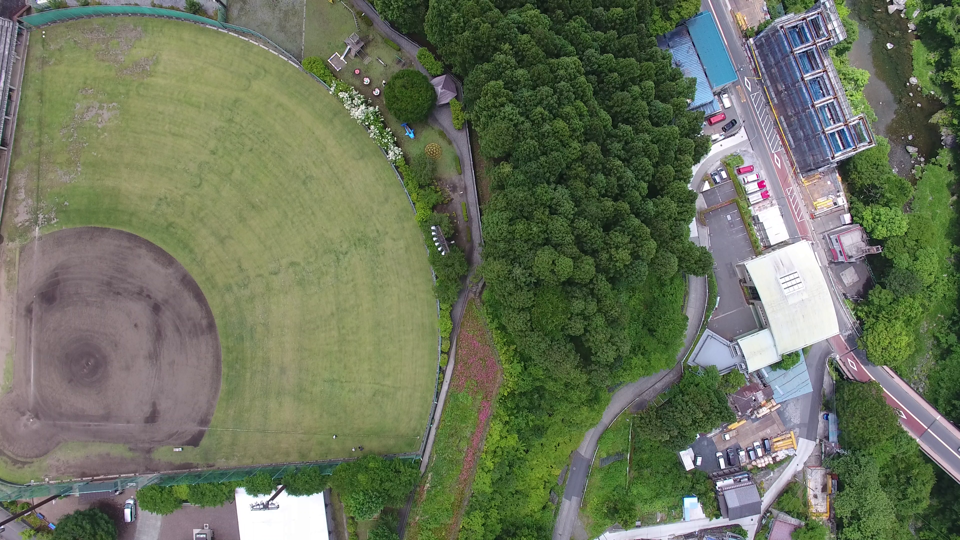

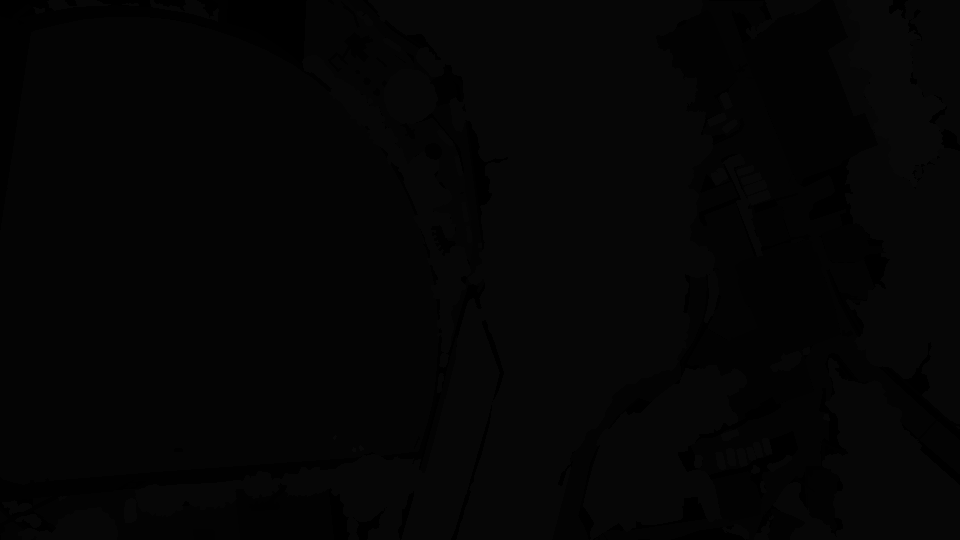

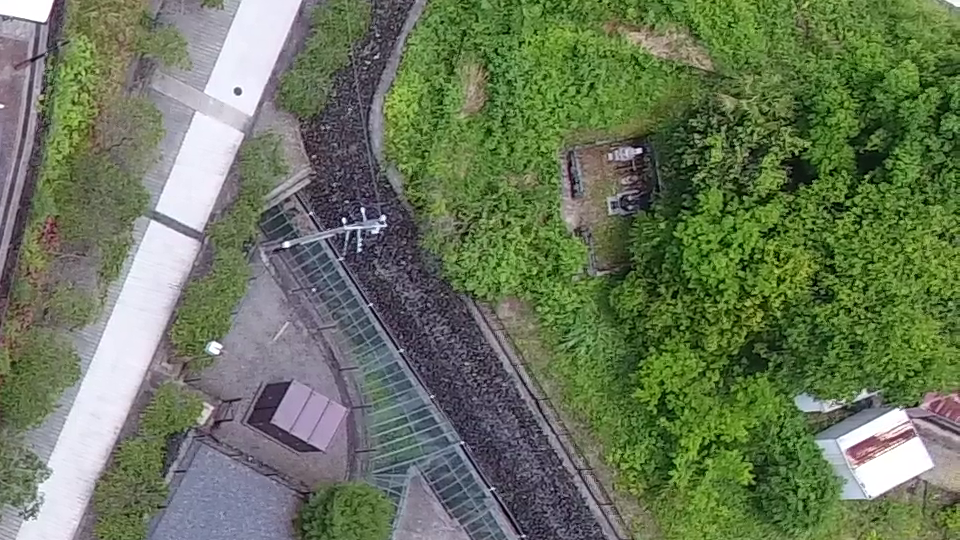

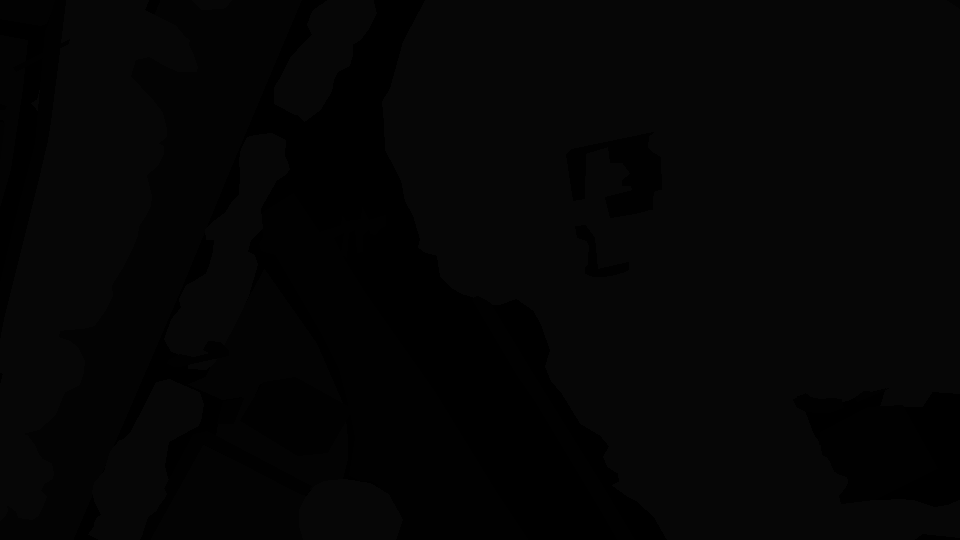

In [6]:
ls_down = os.listdir(img_dir_down)
for i in xrange(1):
    idx = random.randint(0,len(ls_down)-1)
    display(Image(os.path.join(img_dir_down, ls_down[idx])))
    display(Image(os.path.join(gt_dir_down, ls_down[idx])))
    
ls_crop = os.listdir(img_dir_crop)
for i in xrange(1):
    idx = random.randint(0,len(ls_crop)-1)
    display(Image(os.path.join(img_dir_crop, ls_crop[idx])))
    display(Image(os.path.join(gt_dir_crop, ls_crop[idx])))

## Simple statistics for dataset balance check

We want to divide the dataset in different splits for training, validation and test. As not all images have all classes, we have to take this into account when doing the split. We want to have all classes in all splits. We will count the classes that appear in each image and the number of pixels they represent over all the dataset to do this division.

In [7]:
def calc_class_hist_from_file(img_file, img_dir):
    assert img_file is not None
    gt_file = os.path.join(img_dir, img_file)
    gt = cv2.imread(gt_file)
    return calc_class_hist(gt)

def calc_class_hist(img):
    return cv2.calcHist([img],[0],None,[10],[0,10])


hist_list_down = []
for f in ls_down:
    hist_list_down.append(calc_class_hist_from_file(f, gt_dir_down))
hist_down_dict = dict(zip(ls_down, hist_list_down))


hist_list_crop = []
for f in ls_crop:
    hist_list_crop.append(calc_class_hist_from_file(f, gt_dir_crop))
hist_crop_dict = dict(zip(ls_crop, hist_list_crop))

In [8]:
def read_class_mapping(class_file):
    with open(class_file, 'r') as f:
        class_mapping = {}
        labels = []
        for idx, line in enumerate(f):
            labels.append(line.split(':')[1].strip(' \t\n\r'))
            class_mapping[labels[-1]] = idx
        return class_mapping, labels
            
class_mapping, labels = read_class_mapping(os.path.join(ROOT, os.path.join('Okutama', 'Class_list.txt')))
print('Our classes: ', *labels)

Our classes:  Background Outdoor structures Buildings Paved ground Non-paved ground Train tracks Plants Wheeled vehicles Water People


Let's see the distribution of classes in the dataset according to their number of pixels

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Humor Sans', u'Comic Sans MS', u'StayPuft'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


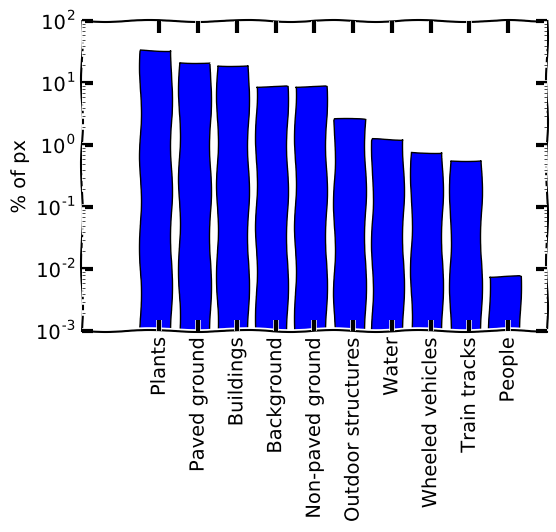

In [9]:
def plot_histogram(labels, values, ylabel='',
                   yaxis_scale='linear', sort=True,
                   title='', stacked=False, legend=[]):
    if sort and not stacked:
        tup = sorted(zip(values, labels), reverse=True)
        labels = [x for (y, x) in tup]
        values = [y for (y, x) in tup]
    fig, ax = plt.subplots()
    if stacked:
        handles = []
        accv = np.zeros(len(labels))
        for v in values:
            handles.append(ax.bar(np.array(range(len(labels)))-0.5, v,
                                  bottom=accv, color=np.random.rand(3,1)))
            accv += np.squeeze(v)
        plt.legend(handles, legend)
    else:
        ax.bar(np.array(range(len(labels)))-0.5, values)
    plt.xticks(range(len(labels)), labels, rotation='vertical')
    plt.title(title)
    ax.set_yscale(yaxis_scale)
    ax.set_ylabel(ylabel)
    plt.show()
    return labels

hist_matrix_down=np.array(hist_list_down)
percent_pixels_per_class = hist_matrix_down.sum(axis=0)/hist_matrix_down.sum()*100
_ = plot_histogram(labels, percent_pixels_per_class, ylabel='% of px', yaxis_scale='log')


Now according to the number of images in which they appear:

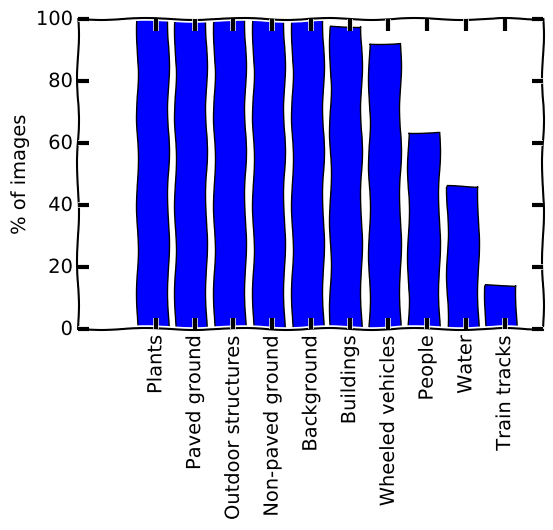

In [10]:
hist_matrix_img=hist_matrix_down>0
percent_images_with_class = hist_matrix_img.sum(axis=0)/float(hist_matrix_img.shape[0])*100

labels_sorted_down = plot_histogram(labels, percent_images_with_class, ylabel='% of images', yaxis_scale='linear')

And for the cropped version:

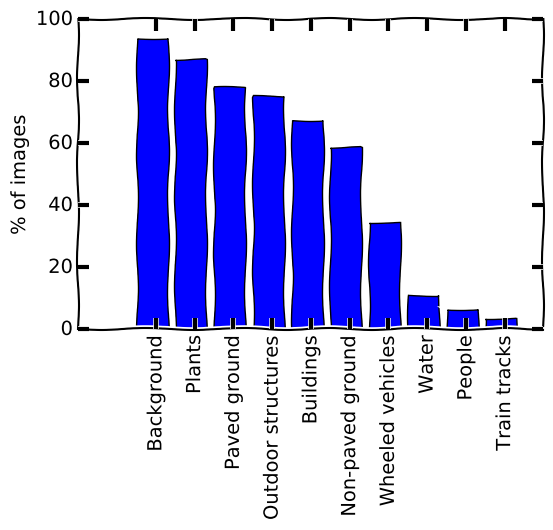

In [11]:
hist_matrix_crop=np.array(hist_list_crop)
hist_matrix_bin_crop=hist_matrix_crop>0

percent_img_crop = hist_matrix_bin_crop.sum(axis=0)/float(hist_matrix_crop.shape[0])*100
labels_sorted_crop = plot_histogram(labels, percent_img_crop, ylabel='% of images', yaxis_scale='linear')

## Define train, test and validation splits

According to the number of images in which each class appears, define the splits and validate that they are more balanced. It is only done in the downsample image as we want that all crops from a same image end up in the same split so we split the cropped version of the dataset according to the other split.

In [12]:
def do_splits_with_hist(ls, gt_dir, test_rel_size, hist_list, class_mapping, labels_sorted):

    # Copy list of images and shuffle it
    ls_copy = copy.deepcopy(ls)
    random.shuffle(ls_copy)
    
    hist_dict = dict(zip(ls, hist_list))

    ls_test = []
    ls_train = []
    i = 0
    
    hist_matrix_img = np.array(hist_list) > 0.
    imax = test_rel_size * hist_matrix_img.sum(axis=0)
    # iterate over list of labels, sorted according to appearance rate in dataset per image
    for l in reversed(labels_sorted):
        # iterate over the files, those in which the class appears
        gen = (f for f in ls_copy if hist_dict[f][class_mapping[l]])
        for f in gen:
            if i < imax[class_mapping[l]]:
                ls_test.append(f)
                i += 1
            else:
                ls_train.append(f)
            ls_copy.remove(f)
        h = np.sum(np.array([calc_class_hist_from_file(f, gt_dir) for f in ls_test]) > 0., axis=0)
        i = h[class_mapping[l]] # This is not correct but it works fine mmmm
    if len(ls_copy)>0:
        ls_train.extend(ls_copy)
    
    return ls_train, ls_test

ls_train_down, ls_test_down = do_splits_with_hist(ls_down, gt_dir_down, 0.16,
                                                  hist_list_down, class_mapping,
                                                 labels_sorted_down)
ls_train_down, ls_val_down = do_splits_with_hist(ls_train_down,gt_dir_down,0.12,
                                                 hist_list_down,class_mapping,
                                                 labels_sorted_down)
print('Train size: ', len(ls_train_down))
print('Test size: ', len(ls_test_down))
print('Val size: ', len(ls_val_down))

Train size:  59
Test size:  16
Val size:  16


Train size:  59
Test size:  16
Val size:  16


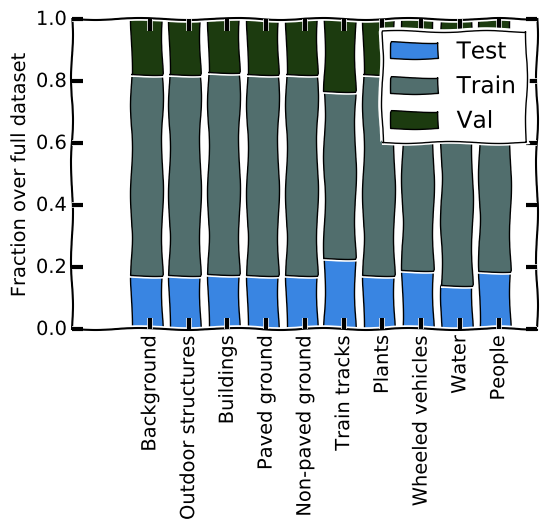

In [13]:
def plot_splits(ls_train, ls_test,ls_val,  gt_dir, hist_list):
    hist_matrix_img = np.array(hist_list) > 0.
    h_train = np.sum(np.array([calc_class_hist_from_file(f, gt_dir) for f in ls_train]) > 0., axis=0)
    h_test = np.sum(np.array([calc_class_hist_from_file(f, gt_dir) for f in ls_test]) > 0., axis=0)
    h_val = np.sum(np.array([calc_class_hist_from_file(f, gt_dir) for f in ls_val]) > 0., axis=0)
    hist_train_test_val = (np.divide(h_train,  hist_matrix_img.sum(axis=0).astype(float)), np.divide(h_test,  hist_matrix_img.sum(axis=0).astype(float)),
                          np.divide(h_val,  hist_matrix_img.sum(axis=0).astype(float)))
    legend = ('Test', 'Train','Val')
    _ = plot_histogram(labels, hist_train_test_val, ylabel='Fraction over full dataset', legend=legend, stacked=True)
    
print('Train size: ', len(ls_train_down))
print('Test size: ', len(ls_test_down))
print('Val size: ', len(ls_val_down))
plot_splits(ls_test_down, ls_train_down,ls_val_down, gt_dir_down, hist_list_down)

We simply extend the list of the downsample version to have the list for the cropped version. This could also be done as for the downsample version giving the total number of images to the splitting algorithm. Like this the splits are equal than in the previous case but the total fraction of images over the full dataset changes, although seems still reasonably balanced.

Train size:  944
Test size:  256
Val size:  256


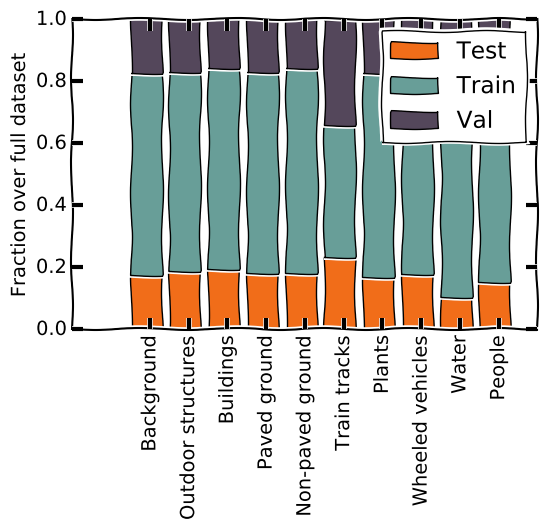

In [14]:
def extend_cropped_filename(ls, crops):
    ls_cropped = []
    for f in ls:
        tmp_f = f.replace('.png','')
        for i in range(0,crops*crops):
            out_f= tmp_f + '_' + str(i)+'.png'
            ls_cropped.append(out_f)
    return ls_cropped

ls_test_cropped = extend_cropped_filename(ls_test_down, crops)
ls_train_cropped = extend_cropped_filename(ls_train_down, crops)
ls_val_cropped = extend_cropped_filename(ls_val_down,crops)
print('Train size: ', len(ls_train_cropped))
print('Test size: ', len(ls_test_cropped))
print('Val size: ',len(ls_val_cropped))
plot_splits(ls_test_cropped, ls_train_cropped,ls_val_cropped, gt_dir_crop, hist_list_crop)


## Create dir and `list.txt` files for each split

In [15]:
def compute_mean(ls, img_dir, path):
    R = 0.0
    G = 0.0
    B = 0.0
    idx = len(ls)
    for imgfile in ls:
        img = cv2.imread(os.path.join(img_dir, imgfile))
        npxl = img.shape[0]*img.shape[1]
        img = np.reshape(img,(npxl,3))
        img = np.ndarray.sum(img,axis=0)/npxl
        B += img[0]
        G += img[1]
        R += img[2]
    mean=[R/idx,G/idx,B/idx]
    with open(os.path.join(path,'mean.txt'),'wb') as list_file:
        list_file.write('B: '+str(mean[0])+' G: '+str(mean[1])+' R: '+str(mean[2]))
    print('Mean file created at:', path)
    print('Mean', mean)



In [16]:
def create_list_file(ls, path, data_folders):
    if not os.path.exists(path):
        with open(path,'wb') as list_file:
            for f in ls:
                list_file.write(os.path.join(data_folders[0], f)+' '+
                                os.path.join(data_folders[1],f)+'\n')

def create_split_dir(dataset_path, split, ls, img_dir, gt_dir):
    split_path = os.path.join(dataset_path, split)
    new_img_dir = os.path.join(split_path, 'images')
    new_gt_dir = os.path.join(split_path, 'ground_truth')
    if not os.path.exists(new_img_dir) and not os.path.exists(new_gt_dir):
        os.makedirs(new_img_dir)
        os.makedirs(new_gt_dir)
        compute_mean(ls,img_dir,split_path)
        for f in ls:
            os.rename(os.path.join(img_dir, f), os.path.join(new_img_dir, f))
            os.rename(os.path.join(gt_dir, f), os.path.join(new_gt_dir, f))
        create_list_file(ls, os.path.join(split_path, split+'.txt'), (new_img_dir, new_gt_dir))
    else:
        raise Exception('Directory already exists')    

In [17]:
# Move files

dataset_name = 'Okutama'
version_name = 'down_4'
dataset_path = os.path.join(ROOT, dataset_name, version_name)

create_split_dir(dataset_path, 'train', ls_train_down, img_dir_down, gt_dir_down)
create_split_dir(dataset_path, 'test', ls_test_down, img_dir_down, gt_dir_down)
create_split_dir(dataset_path, 'val', ls_val_down, img_dir_down, gt_dir_down)

dataset_name = 'Okutama'
version_name = 'crop_4'
dataset_path = os.path.join(ROOT, dataset_name, version_name)


create_split_dir(dataset_path, 'train', ls_train_cropped, img_dir_crop, gt_dir_crop)
create_split_dir(dataset_path, 'test', ls_test_cropped, img_dir_crop, gt_dir_crop)
create_split_dir(dataset_path, 'val', ls_val_cropped, img_dir_crop, gt_dir_crop)

Mean file created at: /home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/down_4/train
Mean [103.8135593220339, 113.47457627118644, 96.254237288135599]
Mean file created at: /home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/down_4/test
Mean [109.1875, 115.3125, 100.625]
Mean file created at: /home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/down_4/val
Mean [102.1875, 110.875, 93.3125]
Mean file created at: /home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/crop_4/train
Mean [103.79978813559322, 113.47881355932203, 96.230932203389827]
Mean file created at: /home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/crop_4/test
Mean [109.109375, 115.47265625, 100.515625]
Mean file created at: /home/miquelmr/Documents/DroneSegmentation/datasets/Okutama/crop_4/val
Mean [102.30859375, 110.87890625, 93.2578125]
Finish moving files


## Create LMDB files for each split

NOT IMPLEMENTED - DIGITS AT THE MOMENT